In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/dataset-flowers/flower_images/train/train/133.png
/kaggle/input/dataset-flowers/flower_images/train/train/34.png
/kaggle/input/dataset-flowers/flower_images/train/train/120.png
/kaggle/input/dataset-flowers/flower_images/train/train/100.png
/kaggle/input/dataset-flowers/flower_images/train/train/128.png
/kaggle/input/dataset-flowers/flower_images/train/train/19.png
/kaggle/input/dataset-flowers/flower_images/train/train/130.png
/kaggle/input/dataset-flowers/flower_images/train/train/48.png
/kaggle/input/dataset-flowers/flower_images/train/train/93.png
/kaggle/input/dataset-flowers/flower_images/train/train/79.png
/kaggle/input/dataset-flowers/flower_images/train/train/16.png
/kaggle/input/dataset-flowers/flower_images/train/train/57.png
/kaggle/input/dataset-flowers/flower_images/train/train/51.png
/kaggle/input/dataset-flowers/flower_images/train/train/40.png
/kaggle/input/dataset-flowers/flower_images/train/train/98.png
/kaggle/input/dataset-flowers/flower_images/train/

In [2]:
from skimage.color import rgb2lab, lab2rgb, gray2rgb
from skimage.io import imsave
from skimage.transform import resize
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from keras.layers import Conv2D, Flatten, Reshape, MaxPooling2D, UpSampling2D
from keras.models import Sequential
from keras.models import Model
from keras import optimizers
import keras
import cv2
import os

Using TensorFlow backend.


Using VGG16 and as it is expecting an image of 3 dimension with size 224x224 as an input, in preprocessing we have to scale all images to 224.

In [3]:
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

train_datagen = ImageDataGenerator(rescale=1. / 255)

train_dataset = train_datagen.flow_from_directory('../input/dataset-flowers/flower_images/train/',target_size= (224,224),
                                                  batch_size = 32, class_mode = None)

Found 143 images belonging to 1 classes.


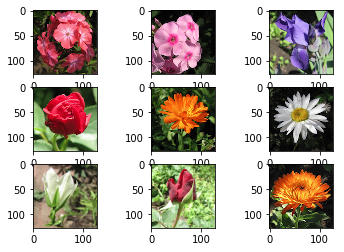

In [4]:
#images from train dataset
from matplotlib.image import imread
from matplotlib import pyplot

folder = '../input/dataset-flowers/flower_images/train/'
# plot first few images
for i in range(1, 10):
    # define subplot
    pyplot.subplot(330 + 0 + i)
    # define filename
    filename = folder +  train_dataset.filenames[i]
    # load image pixels
    image = imread(filename)
    # plot raw pixel data
    pyplot.imshow(image)
# show the figure
pyplot.show()

Convert from RGB to Lab :By iterating on each image, we convert the RGB to Lab. Think of LAB image as a grey image in L channel and all color info stored in A and B channels. The input to the network will be the L channel, so we assign L channel to X vector. And assign A and B to Y.

In [5]:
#Geting the images into Lab color space and taking L, a, a channels seperately 
X = []
Y = []
for img in train_dataset[0]:
    try:
        lab = rgb2lab(img)
        X.append(lab[:,:,0])
        Y.append(lab[:,:,1:] / 128) #a,b channel range is from -127 to 128
    
    except:
        print('Error')
        
X = np.array(X)
Y = np.array(Y)

X = X.reshape(X.shape+(1,))

print(X.shape) #L-channel
print(Y.shape) #a,b channels

(32, 224, 224, 1)
(32, 224, 224, 2)


we are replacing the encoder part with VGG16, we don’t need it as a classifier, we need it as a feature extractor so, the last dense layers isn’t needed we have to pop them up. here, we iterate on each layer except the last dense layers so, we add 19 layer to our model. the dimension of last layer volume is “7x7x512”. we will be using that latent space volume as a feature vector to be input to the decoder. and the decoder is going to learn the mapping from the latent space vector to ab channels. we want the layers of VGG16 with its original weights without changing them, so that we set the trainable parameter in each layer to false because we don’t want to train them again.

In [6]:
#Using VGG16 pretrained model for feature extraction

from keras.applications.vgg16 import VGG16

vgg_model = VGG16()
vgg_model.summary()

553467904/553467096 [==============================] - 12s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
___________________________________________________________

In [7]:
#Encoder
encoder = Sequential()

#Taking layers till 18th 
for i, layer in enumerate(vgg_model.layers):
    if i<19:
        encoder.add(layer)

#Using the prerained weights from vgg pretrained model
for layer in encoder.layers:
    layer.trainable = False

we have one channel of L in each layer but, VGG16 is expecting 3 dimension, so repeating the L channel two more times to get 3 dimensions of the same L channel

In [8]:
feature = []

for i, image in enumerate(X):
    image = gray2rgb(image) #making 3 channels in X which has 1 channel
    image = image.reshape(1, 224, 224, 3)
    prediction = encoder.predict(image)
    prediction = prediction.reshape(7, 7, 512)
    feature.append(prediction)

feature = np.array(feature)
print(feature.shape)

(32, 7, 7, 512)


In [9]:
#decoder
decoder = Sequential()
decoder.add(Conv2D(256, (3, 3), activation='relu', padding='same', input_shape = (7, 7, 512))) #size = 7*7*256
decoder.add(Conv2D(128, (3, 3), activation = 'relu', padding = 'same')) #size = 7*7*128
decoder.add(UpSampling2D((2, 2))) #size = 14*14*128
decoder.add(Conv2D(64, (3, 3), activation = 'relu', padding = 'same')) #size = 14*14*64
decoder.add(UpSampling2D((2, 2))) #size= 28*28*64
decoder.add(Conv2D(32, (3, 3), activation = 'relu', padding = 'same')) #size = 28*28*32
decoder.add(UpSampling2D((2, 2))) #size = 56*56*32
decoder.add(Conv2D(16, (3, 3), activation = 'relu', padding = 'same')) #size = 56*56*16
decoder.add(UpSampling2D((2, 2))) #size = 112*112*16
decoder.add(Conv2D(2, (3, 3), activation = 'tanh', padding = 'same')) #size = 112*112*2
decoder.add(UpSampling2D((2, 2))) #size = 224*224*2

decoder.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 7, 7, 256)         1179904   
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         295040    
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        73792     
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 32)        18464     
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 56, 56, 32)       

In [10]:
decoder.compile(optimizer='Adam', loss='mse', metrics = ['accuracy'])
decoder.fit(feature, Y, verbose = 1, epochs = 100, batch_size= 128)
decoder.save("Image-colorization-using-VGG16.h5")

Epoch 1/100
32/32 [==============================] - 1s 30ms/step - loss: 0.5065 - accuracy: 0.5808
Epoch 2/100
32/32 [==============================] - 1s 19ms/step - loss: 0.8613 - accuracy: 0.2915
Epoch 3/100
32/32 [==============================] - 1s 19ms/step - loss: 0.5242 - accuracy: 0.6956
Epoch 4/100
32/32 [==============================] - 1s 19ms/step - loss: 0.5644 - accuracy: 0.7044
Epoch 5/100
32/32 [==============================] - 1s 19ms/step - loss: 0.8175 - accuracy: 0.6917
Epoch 6/100
32/32 [==============================] - 1s 19ms/step - loss: 0.8380 - accuracy: 0.6661
Epoch 7/100
32/32 [==============================] - 1s 19ms/step - loss: 0.7887 - accuracy: 0.7000
Epoch 8/100
32/32 [==============================] - 1s 20ms/step - loss: 0.6842 - accuracy: 0.7156
Epoch 9/100
32/32 [==============================] - 1s 19ms/step - loss: 0.8286 - accuracy: 0.7169
Epoch 10/100
32/32 [==============================] - 1s 19ms/step - loss: 0.5681 - accuracy: 0.7167

Epoch 83/100
32/32 [==============================] - 1s 23ms/step - loss: 0.0123 - accuracy: 0.8558
Epoch 84/100
32/32 [==============================] - 1s 19ms/step - loss: 0.0122 - accuracy: 0.8567
Epoch 85/100
32/32 [==============================] - 1s 20ms/step - loss: 0.0121 - accuracy: 0.8575
Epoch 86/100
32/32 [==============================] - 1s 21ms/step - loss: 0.0120 - accuracy: 0.8583
Epoch 87/100
32/32 [==============================] - 1s 21ms/step - loss: 0.0119 - accuracy: 0.8593
Epoch 88/100
32/32 [==============================] - 1s 19ms/step - loss: 0.0118 - accuracy: 0.8604
Epoch 89/100
32/32 [==============================] - 1s 19ms/step - loss: 0.0117 - accuracy: 0.8610
Epoch 90/100
32/32 [==============================] - 1s 19ms/step - loss: 0.0116 - accuracy: 0.8616
Epoch 91/100
32/32 [==============================] - 1s 20ms/step - loss: 0.0115 - accuracy: 0.8627
Epoch 92/100
32/32 [==============================] - 1s 19ms/step - loss: 0.0114 - accurac

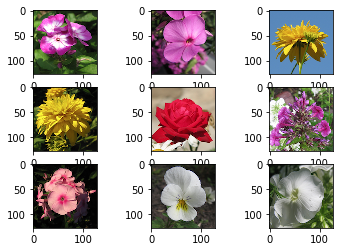

In [11]:
#Displaying few test images
folder = '../input/dataset-flowers/flower_images/test/test/'
# plot first few images
for i in range(1, 10):
    # define subplot
    pyplot.subplot(330 + 0 + i)
    # define filename
    filename = folder +  str(i)+ ".png"
    # load image pixels
    image = imread(filename)
    # plot raw pixel data
    pyplot.imshow(image)
# show the figure
pyplot.show()

In [12]:
#Modifying the test set for prediction

path = '../input/dataset-flowers/flower_images/test/test/'
files = os.listdir(path)

for ids, file in enumerate(files):
       
    img = img_to_array(load_img(path + file))
    img = resize(img, (224,224), anti_aliasing = True)                       
    img*= 1.0 / 255
    lab = rgb2lab(img)
    l = lab[:, :, 0]
    L = gray2rgb(l)
    L = L.reshape(1, 224, 224 ,3)
            
    prediction = encoder.predict(L)
    ab = decoder.predict(prediction)
    
    ab = ab * 128
    reconstructed_img = np.zeros((224, 224, 3))
    reconstructed_img[:, :, 0]= l
    reconstructed_img[:, :, 1:] = ab
    
    imsave('/kaggle/working/reconstructed_img'+ str(ids)+".png" ,lab2rgb(reconstructed_img))
    

/opt/conda/lib/python3.6/site-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 15 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/opt/conda/lib/python3.6/site-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 1 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/opt/conda/lib/python3.6/site-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 184 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/opt/conda/lib/python3.6/site-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 28 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/opt/conda/lib/python3.6/site-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 2 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/opt/conda/lib/python3.6/site-packages/skimage/color/colorconv.py:1068: UserWarning: Color 

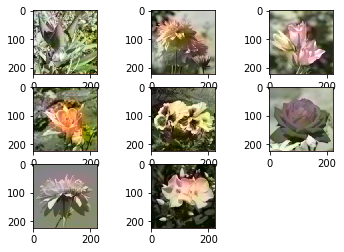

In [13]:
#Predicted images
from matplotlib.image import imread
from matplotlib import pyplot

folder = '/kaggle/working/reconstructed_img'
# plot first few images
for i in range(1,9):
    # define subplot
    pyplot.subplot(330 + 0 + i)
    # define filename
    filename = folder + str(i)+ ".png"
    # load image pixels
    image = imread(filename)
    # plot raw pixel data
    pyplot.imshow(image)
# show the figure
pyplot.show()